<a href="https://colab.research.google.com/github/SaketMunda/dog-breed-prediction/blob/master/dog_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🐶 End-to-end Multi-class Dog Breed Classification

This notebook builds an end-to-end multi-class image classifier using TensorFlow 2.0 and TensorFlow Hub.

## 1. Problem

Identifying the breed of a dog given an image of a dog.

When I'm travelling somewhere outside in any part of the country, and I see different dogs take pictures of them, I want to know the breed of that dog.

## 2. Data

The data we're using is from Kaggle's dog breed identification competition.

https://www.kaggle.com/competitions/dog-breed-identification/data

## 3. Evaluation

The evaluation is a file with prediction probabilities for each dog breed of each test image.

https://www.kaggle.com/competitions/dog-breed-identification/overview/evaluation

## 4. Features

Some information about the data:

* We're dealing with images(unstructured data) so it's probably best we use deep learning/transfer learning.
* There are 120 breeds of dogs (this means there are 120 different classes).
* There are around 10,000+ images in the training set. (these image have labels)
* There are around 10,000+ images in the test set (these images have no labels, because we'll want to predict them).


In [ ]:
# Unzip the data in google drive
# !unzip "drive/MyDrive/Data Science/Dog Vision/dog-breed-identification.zip" -d "drive/MyDrive/Data Science/Dog Vision"

## Get our workspace ready

* Import TensorFlow ✅
* Import TensorFlow Hub ✅
* Make sure GPU is running ✅

In [1]:
# Importing the TensorFlow hub

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:",tf.__version__)
print("TF Hub version:",hub.__version__)


# Check for GPU availability
print("GPU", "available (Yess !!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")


TF version: 2.8.2
TF Hub version: 0.12.0
GPU available (Yess !!!!)


## Getting our data ready (turning into Tensors)

With all the machine learning models, our data has to be in numerical format. So that's what we'll be doing first(numerical representations).

Let's start by accessing our data and checking out the labels.

In [2]:
# Checkout the labels of our data
import pandas as pd
labels_csv = pd.read_csv("drive/MyDrive/Data Science/Dog Vision/labels.csv")
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [ ]:
labels_csv.describe()

,id,breed
count,10222,10222
unique,10222,120
top,000bec180eb18c7604dcecc8fe0dba07,scottish_deerhound
freq,1,126


In [ ]:
labels_csv["breed"].value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64

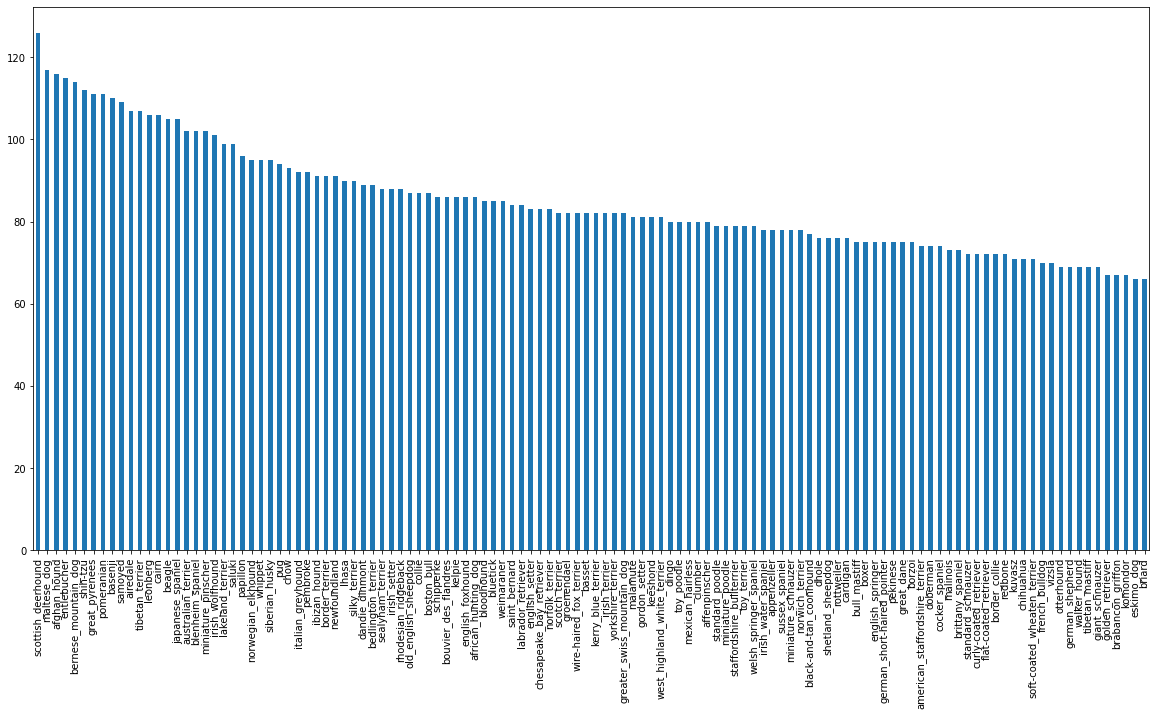

In [ ]:
# Check the distribution of samples per class
labels_csv["breed"].value_counts().plot.bar(figsize =(20, 10));

In [ ]:
# What's the median number of images per class?
labels_csv["breed"].value_counts().median()

82.0

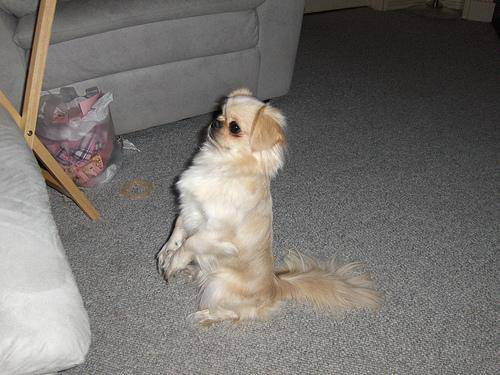

In [ ]:
# Let's view an Image
from IPython.display import Image
Image("drive/MyDrive/Data Science/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg")

## Getting images and their labels

Let's get a list of all of our image file pathnames

In [ ]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [3]:
# Create pathnames from Image's Id

filenames = ["drive/MyDrive/Data Science/Dog Vision/train/" + fname + ".jpg" for fname in labels_csv["id"]]

filenames[:10]

['drive/MyDrive/Data Science/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/Data Science/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/Data Science/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/Data Science/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/Data Science/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/Data Science/Dog Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/Data Science/Dog Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/Data Science/Dog Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/Data Science/Dog Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/Data Science/Dog Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [4]:
# Compare the label counts available in csv with the amount of files/images available in train folder
import os
if len(os.listdir("drive/MyDrive/Data Science/Dog Vision/train/")) == len(filenames):
  print("Filenames match actual amount of files!!! Proceed")
else:
  print("Filenames do not match actual amount of files, check the target directory.")

Filenames match actual amount of files!!! Proceed


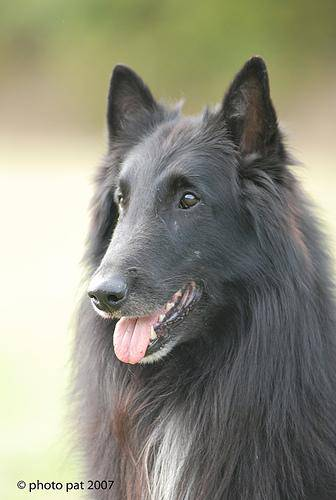

In [ ]:
# One more check
Image(filenames[8500])

In [ ]:
labels_csv["breed"][8500]

'groenendael'

Since we've got our training image filepaths in a list, let's prepare our labels.

In [5]:
labels = labels_csv["breed"].to_numpy()
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [ ]:
len(labels)

10222

In [ ]:
# check the count of labels or missing data
if len(labels) == len(filenames):
  print("We have same amount of labels and files")
else:
  print("Some labels or files are missing, they don't match")

We have same amount of labels and files


In [6]:
# Find the unique labels
import numpy as np
unique_breeds = np.unique(labels)

In [ ]:
len(unique_breeds)

120

In [ ]:
# Turn a single label into an array of booleans
print(labels[2])
print(labels[2]==unique_breeds)
print(labels)

pekinese
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False]


In [7]:
# Turn every label into a boolean array
boolean_label = [label == unique_breeds for label in labels]
boolean_label[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [ ]:
len(boolean_label)

10222

In [ ]:
# Example: Turning boolean array into integers
print(labels[0]) # original label
print(np.where(unique_breeds==labels[0])) # index where label occurs
print(boolean_label[0].argmax()) # index where label occurs in boolean array
print(boolean_label[0].astype(int)) # converting the array into integer

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [ ]:
print(labels[2])
print(boolean_label[2].astype(int))

pekinese
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Creating our own Validation set

Since the dataset from Kaggle doesn't come with a validation set, we're going to create our own.

In [8]:
# Setup X & y variables
X = filenames
y = boolean_label

We're going to start off experimenting with ~1000 images and increase as needed.

In [9]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type: "slider", min:1000, max:10000, step:1000}

In [10]:
# Spliting into Train and Valid set

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state = 42)

len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [ ]:
X_train[:2], y_train[:2]

(['drive/MyDrive/Data Science/Dog Vision/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/MyDrive/Data Science/Dog Vision/train/0d2f9e12a2611d911d91a339074c8154.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False

## Preprocessing Images (Turning Images into Tensors) <-- Tensors because we are using tensorflow

To preprocess our images into Tensors we're going to write a function which does a few things:
1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable, `image`
3. Turn our `image` (a jpg) into Tensors
4. Normalize the tensors by converting it from the range of 0-255 to 0-1
5. Resize the `image` to be a shape of (224,224)
6. Return the modified `image`

Tutorial : https://www.tensorflow.org/tutorials/load_data/images

Before we do, let's see what importing an image looks like.

In [11]:
# Convert an image into Numpy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape 
# imread converted image into an array of the combination of (R, G, B)
# which ranges from 0 to 255

(257, 350, 3)

In [ ]:
image.max(), image.min()

(255, 0)

In [ ]:
# let's convert it to tensors
tf.constant(image)

<tf.Tensor: shape=(257, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]],

       [[ 56, 104,  66],
        [ 58, 106,  66],
        [ 64, 112,  72],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 73, 130,  85]],

       ...,

       [[  2,  11,  10],
        [  5,  14,  13],
        [  6,  15,  14],
        ...,
        [120, 113,  67],
        [126, 118,  72],
        [122, 114,  67]],

       [[  0,   4,   6],
        [  0,   9,   8],
        [  1,  10,   9],
        ...,
        [105,  98,  52],
        [111, 104,  58],
        [111, 103,  56]],

       [[ 18,  16,  37],
        [ 18,  18,  28],
        [ 17,  20,  11],
        ...,
        [101,  92,  5

In [12]:
# writing the preprocess image function
#1. Take an image filepath as input
#2. Use TensorFlow to read the file and save it to a variable, `image`
#3. Turn our `image` (a jpg) into Tensors
#4. Normalize the tensors by converting it from the range of 0-255 to 0-1
#5. Resize the `image` to be a shape of (224,224)
#6. Return the modified `image`

IMG_SIZE = 224

def preprocess_image(image_path, img_size = IMG_SIZE):
  """
  This function take image path and image size as input and turn them into tensors.
  """

  # read the image file from the image path and assign it to a variable
  image = tf.io.read_file(image_path) # this convert it to string or special characters, no readable
  # Turn the jpeg image into numerical tensors with 3 colour channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Normalize the colour channel values from 0-255 to 0-1
  image = tf.image.convert_image_dtype(image, tf.float32)
  # resize the image to be a shape of (224,224)
  image = tf.image.resize(image, size=[img_size, img_size])

  return image

## Turning into batches

Why turn our data into batches ?

Let's say you're trying to process 10,000+ images in one go... they all might not fit into memory.

So that's why we do about 32(this is the batch size) images at a time (you can manually adjust the batch size if need be).

In order to use TensorFlow effectively, we need our data in the form of Tensor tuples which look like this: `(image, label)`

In [13]:
# Create a simple function to return a tuple (image, label)

def get_image_label(image_path, label):
  """
  Takes an image file path name and the associated label,
  process the image and convert the label into Tensors and return a tuple of (image, label).
  """
  return preprocess_image(image_path), label

In [ ]:
# check if it is working for single image
demo_tensor = get_image_label(X[42], y[42])
demo_tensor

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

Now we've got a way to turn our data into tuples of Tensors in the form: `(image,label)`, let's make a function to turn the data into batches!

In [14]:
# Define the batch size, 32 is a good start
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (X) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle if it's validation data.
  Also accepts test data as input (no label)
  """

  # If the data is a test dataset, we probably don't have labels
  if test_data:
    print("Creating batches for test data....")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only filepaths (no labels)
    data_batch = data.map(preprocess_image).batch(batch_size)
    return data_batch
  # if the data is validation dataset, we do have labels but we don't need to shuffle it
  elif valid_data:
    print("Creating batches for validation data...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
    data_batch = data.map(get_image_label).batch(batch_size)
    return data_batch
  else:
    print("Creating batches for Training data....")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(X))

    # Create (image, label) tuples (this also turns the image path into a preprocessed image) and turn them into batches
    data_batch = data.map(get_image_label).batch(batch_size)

    return data_batch 


In [15]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
valid_data = create_data_batches(X_val,y_val, valid_data=True)

Creating batches for Training data....
Creating batches for validation data...


In [ ]:
train_data.element_spec, valid_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualizing Data Batches

Our data is now in batches, however, these can be a little hard to understand/comprehend. Let's plot it

In [16]:
# Create function to plot the images with it's labels

import matplotlib.pyplot as plt

def show_25_images(images, labels):
  """
  Displays a plot of 25 images and their labels from a data batch
  """
  # Setup the figure
  plt.figure(figsize=(10,10))
  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # display an image
    plt.imshow(images[i])
    # add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn the grid lines off
    plt.axis("off")


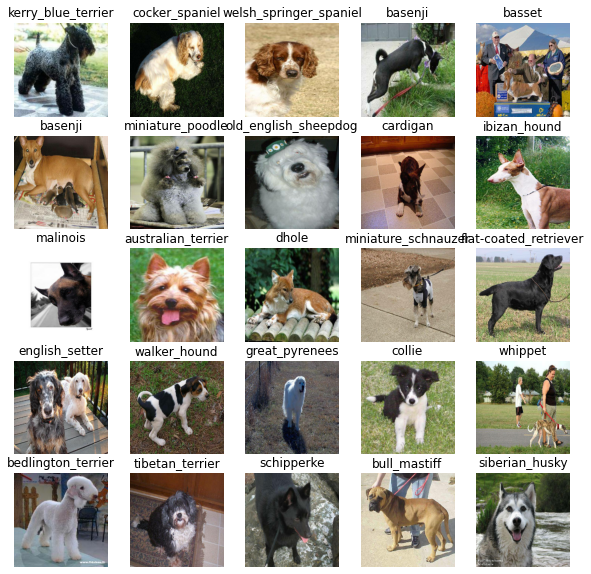

In [17]:
# next() will pop a batch of 32 images, as_numpy_iterator will convert the batch into iteration so that next can pop the batch
# ploting the train set
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

# everytime we run this block will produce new set of images, because we used the shuffle for training set

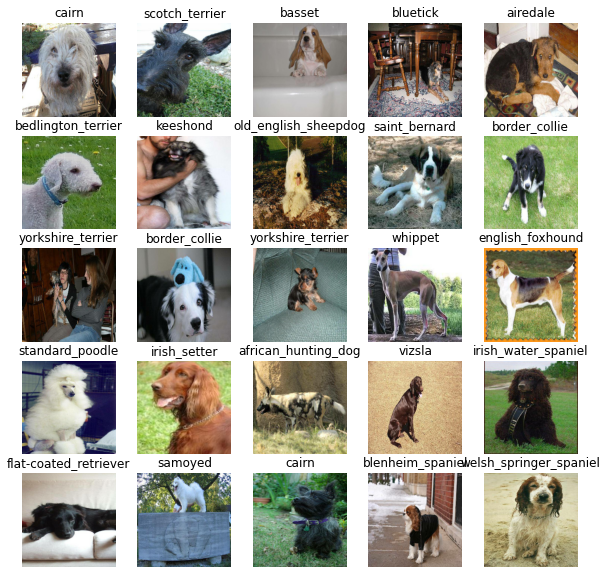

In [18]:
# visualizing the validation set
valid_images, valid_labels = next(valid_data.as_numpy_iterator())
show_25_images(valid_images,valid_labels)

## Building a model

Before we build a model, there are a few things we need to define:

* Input shape (our images shapes, in the form of Tensors) to our model.
* Output shape (image labels, in the form of Tensors) of our model.
* The URL of the model we want to use 
   https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5


In [19]:
# Input Shape
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, color channel

#Output Shape
OUTPUT_SHAPE = len(unique_breeds)

# URL
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

Now we've got our inputs, outputs and model ready to go.
Let's put them together into a Keras deep learning model!

Knowing this, let's create a function which:
* Takes the input shape, output shape and the model url we've chosen as parameters
* Defines the layers in a Keras model in sequential fashion (do this, then this, then that)
* Compiles the model (says it should be evaluated and improved)
* Builds the model (tells the model the input shape it'll be getting)
* Returns the model

All of these steps can be found here : https://www.tensorflow.org/guide/keras/sequential_model


In [20]:
# Create a function which builds a Keras Model

def create_model(input_shape = INPUT_SHAPE, output_shape = OUTPUT_SHAPE, model_url = MODEL_URL):
  print("Building model with:", model_url)

  # Setup the layers in Keras Model
  model = tf.keras.Sequential([
      hub.KerasLayer(model_url), # Layer 1 (input layer)
      tf.keras.layers.Dense(units=output_shape,
                            activation="softmax") # Layer 2 (output layer)
      ])
  
  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer= tf.keras.optimizers.Adam(),
      metrics=['accuracy']
  )

  # Build the model
  model.build(input_shape)

  return model  

In [21]:
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5432713   
                                                                 
 dense (Dense)               (None, 120)               120240    
                                                                 
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


## Creating Callbacks

Callbacks are helper functions a model can use during training to do such things as save its progress, check its progress or stop training early if a model stops improving.

We'll create two callbacks, one for TensorBoard which helps track our models progress and another for early stopping which prevents our model from training for too long.

### TensorBoard Callback

To setup a TensorBoard callback, we need to do 3 things:

1. Load the TensorBoard notebook extension ✅
2. Create a TensorBoard callback which is able to save logs to a directory and pass it to our model's `fit()` function. ✅
3. Visualize our models training logs with the `%tensorboard` magic function(we'll do this after model training) ⏱

In [22]:
# Load tensorboard notebook extension
%load_ext tensorboard

In [23]:
import datetime

# create a function to build a tensorboard callback
def create_tensorboard_callback():
  # Create a log directory for storing Tensorboard logs
  logdir = os.path.join("drive/MyDrive/Data Science/Dog Vision/logs", 
                        #Make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  
  return tf.keras.callbacks.TensorBoard(logdir)

### Early Stopping

Early stopping helps stop a model from overfitting by stopping training if a certain evaluation metrics stops improving.

https://keras.io/api/callbacks/early_stopping/

In [24]:
# create early stopping callback

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3)

## Training a model (on a subset data)

Our first model is only going to train on 1000 images, to make sure everything is working.

In [25]:
# Number of epochs is the number times that a learning algorithm will work through the entire training dataset
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100, step:10}

In [26]:
# Check to make sure we're still runnning on GPU
print("GPU", "available (YES !!!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

GPU available (YES !!!!!!)


Let's create a function which trains a model,

* Create a model using `create_model()`
* Setup a Tensorboard callback using `create_tensorboard_callback()`
* Call the `fit()` function on our model passing it the training data, validation data, number of epochs to train for (`NUM_EPOCHS`) and the callbacks we'd like to use
* Return the model

In [27]:
# Creating a function

def train_model():
  print('Training our Deep Learning model...')

  # Create a model
  model = create_model()
  # create a new tensorboard session everytime we train a model
  tensorboard = create_tensorboard_callback()
  # fit the model to the data passing it the callback we created
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=valid_data,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping])  
  # Return the fitted model
  return model

In [28]:
# Fit the model to the data
model = train_model()

Training our Deep Learning model...
Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Epoch 1/100
25/25 [==============================] - 135s 4s/step - loss: 4.7020 - accuracy: 0.1037 - val_loss: 3.4209 - val_accuracy: 0.2500
Epoch 2/100
25/25 [==============================] - 5s 185ms/step - loss: 1.6865 - accuracy: 0.6612 - val_loss: 2.1445 - val_accuracy: 0.5100
Epoch 3/100
25/25 [==============================] - 4s 170ms/step - loss: 0.5823 - accuracy: 0.9362 - val_loss: 1.6367 - val_accuracy: 0.5950
Epoch 4/100
25/25 [==============================] - 5s 188ms/step - loss: 0.2592 - accuracy: 0.9887 - val_loss: 1.4137 - val_accuracy: 0.6450
Epoch 5/100
25/25 [==============================] - 4s 179ms/step - loss: 0.1479 - accuracy: 0.9975 - val_loss: 1.3353 - val_accuracy: 0.6600
Epoch 6/100
25/25 [==============================] - 4s 167ms/step - loss: 0.1021 - accuracy: 1.0000 - val_loss: 1.2939 - val_accuracy: 0.6650
Epoch 7/100
25

**Question:** It looks like our model is overfitting because it's performing far better on the training dataset than the validation dataset, what are some ways to prevent model overfitting in deep learning neural networks?

**Note:** Overfitting to begin with is a good thing! It means our model is learning!!!

## Checking the Tensorboard logs

The Tensorboard magic function `%tensorboard` will access the logs directory we created earlier and visualize its contents.

In [29]:
%tensorboard --logdir drive/MyDrive/Data\ Science/Dog\ Vision/logs

<IPython.core.display.Javascript object>

## Making and Evaluating predictions using a trained model

In [30]:
valid_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [31]:
# make predictions on the validation data (not used to train to)
# validation is done on 200 samples divided into batches of 32 each
predictions = model.predict(valid_data, verbose=1)
predictions

7/7 [==============================] - 2s 130ms/step


array([[1.3489719e-02, 6.1416751e-05, 3.0734483e-03, ..., 7.1857200e-04,
        1.2160529e-04, 1.0855129e-02],
       [4.3251514e-03, 1.2410032e-03, 5.4498767e-03, ..., 1.0277301e-03,
        2.3849790e-03, 1.3170441e-04],
       [5.6793004e-05, 2.0374038e-04, 4.1660378e-04, ..., 9.3391216e-05,
        9.1966809e-05, 4.5495754e-04],
       ...,
       [7.7446020e-06, 9.6998738e-06, 3.1962623e-05, ..., 2.6906040e-05,
        1.0281103e-04, 2.9627001e-05],
       [7.6626209e-03, 1.4340706e-04, 4.5795779e-04, ..., 1.6570694e-04,
        1.7164789e-04, 4.8061334e-02],
       [4.9906509e-04, 2.7378293e-05, 5.1511166e-04, ..., 2.6263166e-03,
        3.2187279e-03, 3.2119162e-04]], dtype=float32)

In [ ]:
# if we check the shape of predictions, 
predictions.shape

(200, 120)

In [ ]:
# this will show the first index value of predictions, containing, X as an array of probability of prediction for each y labels
predictions[0]

array([6.9362777e-03, 1.7972589e-04, 4.5521501e-03, 3.5938289e-04,
       1.7509755e-03, 7.1388742e-05, 1.8973926e-02, 2.2220856e-04,
       1.0193110e-03, 1.0275354e-04, 1.9352977e-03, 3.9469076e-05,
       9.7622084e-05, 1.6393814e-04, 7.1910996e-04, 2.2276766e-04,
       6.2734631e-05, 5.5987258e-02, 5.2088948e-05, 2.1416413e-04,
       6.5057597e-04, 8.0393383e-04, 7.5066477e-05, 1.4855411e-03,
       1.1469130e-04, 4.6824851e-05, 1.6273546e-01, 4.8225865e-04,
       8.0467365e-04, 1.0399648e-03, 2.4677554e-04, 2.2315274e-03,
       9.0164394e-04, 1.7580643e-04, 3.7483926e-04, 1.7471924e-01,
       3.5690544e-05, 1.0491105e-03, 1.5380536e-04, 3.6661024e-04,
       1.4471790e-03, 3.5248777e-05, 8.2614482e-05, 2.7249745e-04,
       2.0286902e-04, 1.6985551e-04, 3.7150821e-05, 1.1345386e-03,
       1.2081391e-03, 2.6287412e-04, 6.7525922e-04, 6.3710308e-05,
       1.4624542e-04, 2.9968416e-05, 1.2097105e-03, 6.0324423e-04,
       1.0071580e-03, 3.7228462e-04, 1.8625985e-03, 7.2560616e

In [ ]:
# above will be more descriptive if we see both together
len(unique_breeds), len(predictions[0]) 

(120, 120)

In [ ]:
# and the sum of all the values in that array will be closer to 1 or around 1, ~ (0,1)
np.sum(predictions[0]), np.sum(predictions[1])

(1.0, 1.0)

In [ ]:
# lets map the first prediction value with it's label to be more descriptive

index = 7
print(predictions[index])
print(f"Max value (probability of prediction / confidence value): {np.max(predictions[index])}")
print(f"Sum: {np.sum(predictions[index])}")
print(f"Index at Max value:{np.argmax(predictions[index])}")
print(f"Predicted label:{unique_breeds[np.argmax(predictions[index])]}")


[5.9676054e-04 9.0677320e-04 5.3942576e-04 2.3966772e-05 4.8936949e-05
 2.2302131e-05 2.9113272e-04 2.6906660e-05 4.2349682e-04 1.7826440e-04
 1.1198085e-02 4.5643409e-04 1.4284120e-05 7.6740311e-04 4.0939622e-04
 4.3484164e-04 4.4439963e-04 8.3207247e-05 4.4371549e-04 1.6617883e-05
 4.5997864e-03 6.3309672e-05 3.5439990e-04 1.4221052e-02 2.5274008e-05
 4.8528137e-04 7.3283026e-04 4.9118455e-05 6.1474944e-05 3.5127658e-05
 6.5880507e-05 5.1909423e-04 5.3419477e-05 1.6132054e-04 2.2399190e-04
 6.9513517e-03 3.8720140e-05 1.0058269e-04 4.7791112e-04 1.8607463e-04
 1.0858089e-04 1.0928931e-04 4.6172828e-04 1.9339017e-04 4.2837470e-05
 7.6450786e-05 5.6433244e-05 1.6626016e-05 2.0867810e-03 2.4972082e-05
 2.3124776e-05 6.7079374e-05 3.5713143e-05 1.7761158e-04 4.9628114e-04
 1.8101699e-05 9.1359238e-05 1.1946155e-04 4.0003728e-05 3.6977669e-03
 1.0381641e-04 1.6931182e-05 7.9892296e-03 2.5975252e-05 3.0337488e-03
 1.5222105e-01 4.7542178e-04 6.8687470e-05 7.1997344e-03 4.0440944e-05
 5.763

In [ ]:
unique_breeds[82]

'old_english_sheepdog'

Having the above functionality is great but we want to be able to do it at scale.

And it would be even better we could see the image the prediction is being made on!

**Note:** Prediction probabilities are also known as confidence levels.

In [32]:
# Turn prediction probabilities into their respective label (easier to understand)

def get_pred_label(prediction_probabilities):
  """
  Turn the prediction probabilities into labels
  """
  return unique_breeds[np.argmax(prediction_probabilities)]

# get a predicted label based on an array of prediction probabilities

pred_label = get_pred_label(predictions[17])
pred_label


'african_hunting_dog'

Now since our validation data is still in a batch dataset, we'll have to unbatchify it to make predictions on the validation images and then compare those predictions to the validation labels (truth labels)

In [39]:
# create a function to unbatch a batch dataset

def unbatchify(data):
  """
  Takes a batched dataset of samples Tensors and return the separate arrays of images and labels.
  """
  images = []
  labels = []

  # loop through the unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])

  return images, labels

In [40]:
# unbatchify the validation data
val_images, val_labels = unbatchify(valid_data)
val_images[0], val_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.2770141 , 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

In [ ]:
# truth label for unbatched validation data at 0 index
get_pred_label(val_labels[0])

'cairn'

In [ ]:
# predicted label on validation data at 0 index
get_pred_label(predictions[0])

'dandie_dinmont'

## Visualize Model Prediction


Now we've got ways to get:

* Prediction lables
* Validation labels (truth labels)
* Validation Images

Let's make some function to make these all a bit more visualize

We'll create a function which:

* Takes an array of prediction probabilities, an array of truth labels and an array of images and an integer. ✅
* Convert the prediction probabilities to a predicted label ✅
* Plot the predicted label, its predicted probability, the truth label and the target image on a single plot. ✅

In [43]:
def plot_pred(prediction_probabilities, labels, images, n = 1):
  """
  Take prediction probabilties, truth labels, validation images and an integer 
  and plot the predicted label, it's probability confidence and the truth label.
  """

  pred_prob, truth_label, image = prediction_probabilities[n], labels[n], images[n]

  # convert the prediction probabilities to a predicted label
  pred_label = get_pred_label(pred_prob)

  # plot image & remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Show the title in green if model predicted correct label else red
  color = "red"
  if pred_label==truth_label:
    color = "green"

  # title of the plot
  plt.title("Model is {:2.0f}% confident on predicting {}, and the actual breed is {}".format(np.max(pred_prob)*100, pred_label, truth_label), color = color );


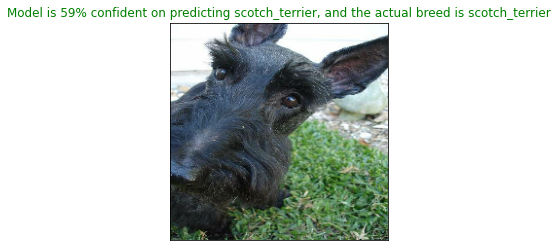

In [44]:
plot_pred(prediction_probabilities=predictions, 
          labels=val_labels,
          images=val_images)

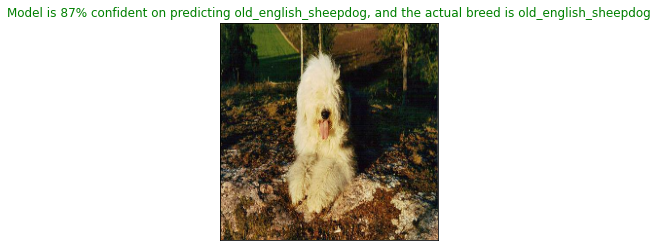

In [45]:
plot_pred(prediction_probabilities=predictions, 
          labels=val_labels,
          images=val_images,
          n = 7)

Now we've got one function to visualize our models top prediction, let's make another to view our models top 10 predictions.

This function will:

* Take an input of prediction probabilities array and a ground truth array and an integer ✅
* Find the prediction using `get_pred_label()` ✅
* Find the top 10:
  * Prediction probabilities indexes ✅
  * Prediction probabilities values ✅
  * Prediction labels ✅
* Plot the top 10 prediction probability values and labels, coloring the true label green. ✅


In [64]:
def plot_top_10_pred(prediction_probabilities, labels, n = 1):
  """
  Takes array of prediction probabilities, labels and index and 
  plot the top 10 highest predictions made for that truth label for sample n.
  """

  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the prediction
  pred_label = get_pred_label(pred_prob)

  # find the top 10 prediction confidence indexes
  top_10_pred_index = pred_prob.argsort()[-10:][::-1]

  # top 10 prediction probabilities values
  top_10_pred_prob = pred_prob[top_10_pred_index]

  # top 10 predicted labels
  top_10_pred_labels = unique_breeds[top_10_pred_index]


  # Setup plotting
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)), 
                     top_10_pred_prob,
                     color="grey")
  
  plt.xticks(np.arange(len(top_10_pred_labels)), 
             labels = top_10_pred_labels,
             rotation="vertical")
  
  # change color of bar for true labels
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass

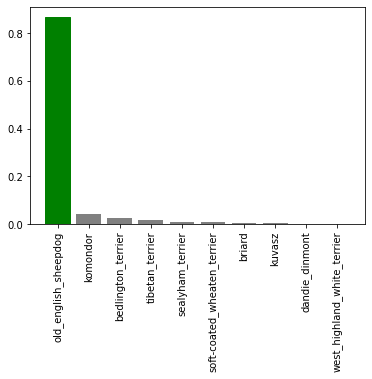

In [65]:
plot_top_10_pred(prediction_probabilities=predictions, labels = val_labels, n = 7)

Now we've got some function to help us visualize our predictions and evaluate our model, let's check out a few

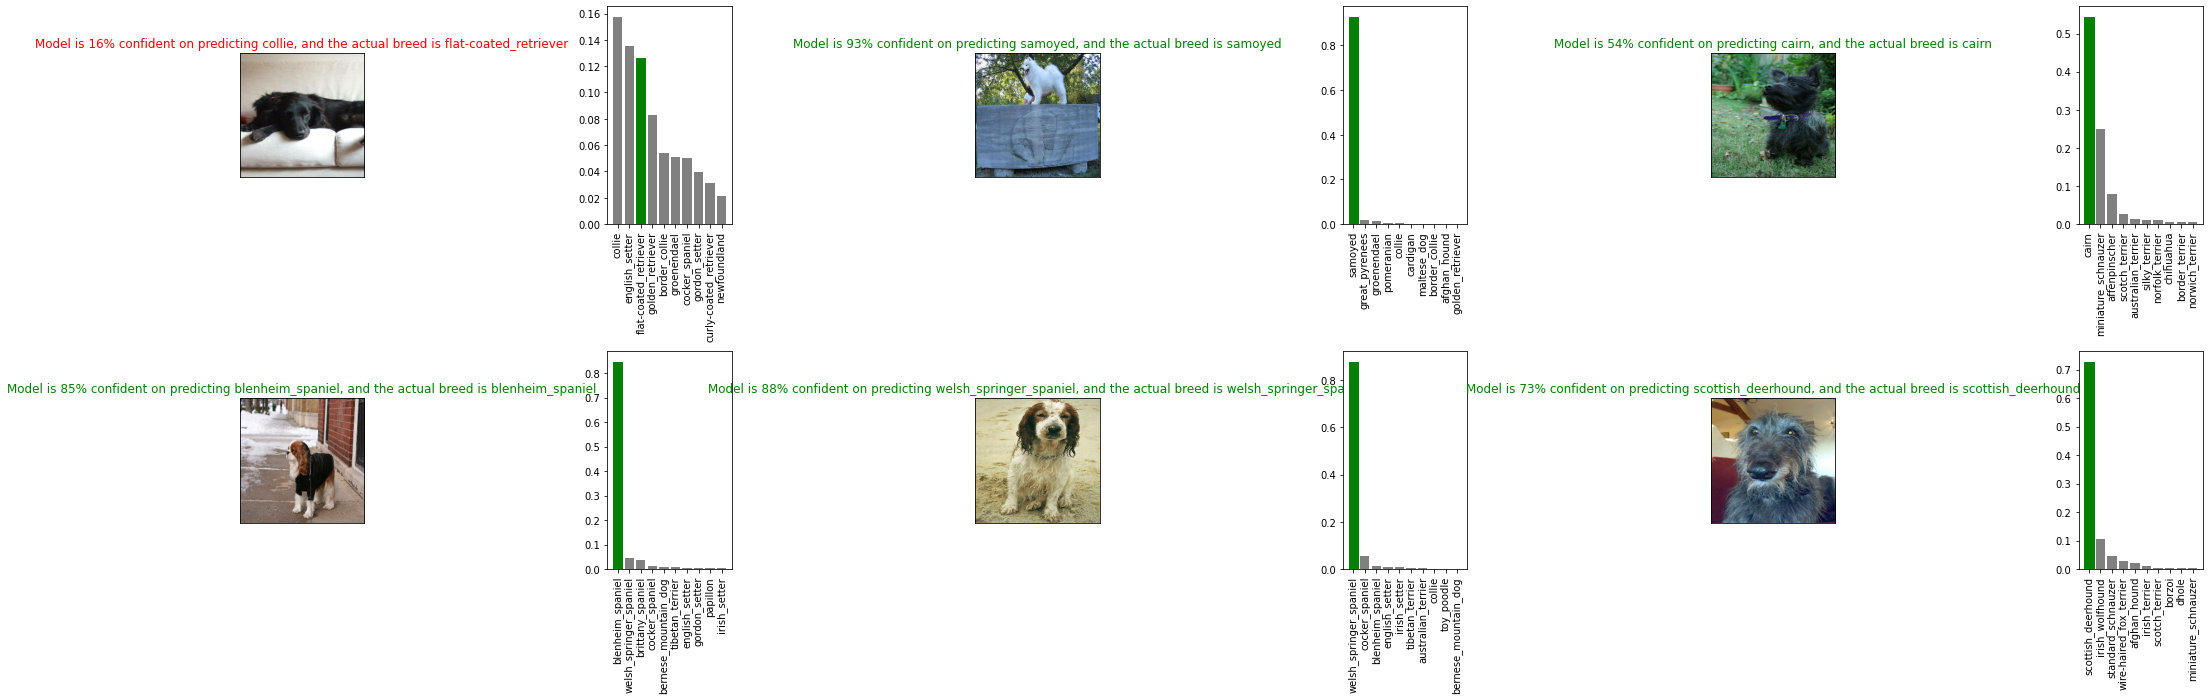

In [74]:
# let's check out a few predictions and their different values
i_multiplier = 20 #@param {type:"slider", min:0, max:100, step:10}
num_rows = 2
num_cols = 3
num_images = num_rows*num_cols

plt.figure(figsize=(10*num_cols, 5*num_rows))

for i in range(num_images):
  # for plotting the sample image with it's prediction percentage
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier)
  # for plotting the top 10 predictions of that sample image
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_top_10_pred(prediction_probabilities=predictions,
                   labels=val_labels,
                   n=i+i_multiplier)
  
plt.tight_layout(h_pad=1.0)
plt.show()

**Challenge**: How would you create a confusion matrix with our models predictions and true labels?

## Saving and Loading the Trained Model

In [75]:
# create function to save a model
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (string).
  """
  # create a model directory pathname with current time
  modeldir = os.path.join("drive/MyDrive/Data\ Science/Dog\ Vision/models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))  
  model_path = modeldir + "-" + suffix + ".h5" # save format of model
  print(f"Saving a trained model to: {model_path}...")
  model.save(model_path)
  return model_path

In [76]:
# create a function to load a trained model
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from:{model_path}")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects = {"KerasLayer": hub.KerasLayer})
  return model  

Now we've got functions to save and load a trained model, let's make sure they work!

In [77]:
# save our model trained on 1000 images
save_model(model, suffix="1000-images-mobilenetv2-Adam")

Saving a trained model to: drive/MyDrive/Data\ Science/Dog\ Vision/models/20220930-04231664511839-1000-images-mobilenetv2-Adam.h5...


'drive/MyDrive/Data\\ Science/Dog\\ Vision/models/20220930-04231664511839-1000-images-mobilenetv2-Adam.h5'

In [78]:
# load a trained model
load_1000_sample_model = load_model("drive/MyDrive/Data\ Science/Dog\ Vision/models/20220930-04231664511839-1000-images-mobilenetv2-Adam.h5")

Loading saved model from:drive/MyDrive/Data\ Science/Dog\ Vision/models/20220930-04231664511839-1000-images-mobilenetv2-Adam.h5


In [79]:
# let's compare the results between saved and loaded
model.evaluate(valid_data)

7/7 [==============================] - 2s 225ms/step - loss: 1.2120 - accuracy: 0.6800


[1.2119853496551514, 0.6800000071525574]

In [80]:
load_1000_sample_model.evaluate(valid_data)

7/7 [==============================] - 2s 142ms/step - loss: 1.2120 - accuracy: 0.6800


[1.2119853496551514, 0.6800000071525574]